In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import pandas as pd
import numpy as np
import pprint
import os
import re

from os import listdir, getcwd

# Disable scientific notation
pd.set_option("display.float_format", "{:.2f}".format)

## Preparing the Dataset

In [2]:
# Getting file path list of each month extracted data
cwd = os.getcwd()
cwd_up = os.path.dirname(cwd) 
path = f"{cwd_up}/data/raw-data/"
data_files = [path + file for file in listdir(path)]

# Concatenate each month data into a single data frame
fipe_data = pd.concat(map(lambda f: pd.read_csv(f, on_bad_lines='skip'), data_files))
fipe_data

,fipe_cod,tabela_id,anoref,mesref,tipo,marca_id,marca,modelo_id,modelo,anomod,comb_cod,comb_sigla,comb,valor
0,038003-2,315,2024,11,1,1,Acura,1,Integra GS 1.8,1992,1,G,Gasolina,11224
1,060003-2,315,2024,11,1,2,Agrale,4564,MARRUÁ AM 100 2.8 CS TDI Diesel,2010,3,D,Diesel,65453
2,060007-5,315,2024,11,1,2,Agrale,4568,MARRUÁ AM 200 2.8 CS TDI Diesel,2018,3,D,Diesel,184848
3,060007-5,315,2024,11,1,2,Agrale,4568,MARRUÁ AM 200 2.8 CS TDI Diesel,2012,3,D,Diesel,93366
4,007002-5,315,2024,11,1,5,Asia Motors,27,Hi-Topic STD Diesel,1998,3,D,Diesel,14775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,015083-5,309,2024,5,1,26,Hyundai,5726,AZERA 3.0 V6 24V 4p Aut.,2013,1,G,Gasolina,72814
76,015101-7,309,2024,5,1,26,Hyundai,6435,HB20S C.Style/C.Plus1.6 Flex 16V Aut. 4p,2014,1,G,Gasolina,48285
77,015219-6,309,2024,5,1,26,Hyundai,10014,HB20S Limited 1.0 Flex 12V Mec.,2023,1,G,Gasolina,78374
78,015051-7,309,2024,5,1,26,Hyundai,1333,Santa Fe GLS 2.7 V6 4x4TipTronic,2004,1,G,Gasolina,24715


In [3]:
fipe_data[['modelo','anomod']].value_counts()

modelo                           anomod
Kadett GL/SL/Lite/Turim 1.8      1995      2
Pampa L 1.8i / 1.8               1995      2
Fiorino Furgão 1.0               1996      2
Escort Ghia 2.0i / 2.0           1995      2
Pampa Ghia 1.6/1.8/DUO           1995      2
                                          ..
Defender 110 2.4 122cv T.Diesel  2007      1
Dakota Sport CE 3.9 V6           1998      1
Dakota Sport CE 2.5 Diesel       1999      1
Dakota Durango 5.9 4x4 V8        1999      1
Defender 130 TDI CD Diesel       1992      1
Name: count, Length: 4692, dtype: int64

### Extracting features

In [4]:
fipe_data['modelo'].sample(50)

27                      A4 2.8 Avant V6 30V Mec.
943           CAPTUR Zen 1.3 TB 16V Flex 5p Aut.
868      Vectra Expres./ Collection  2.0 MPFI 8V
1279                  Defender 130 TDI CD Diesel
58                       DBS Coupe 5.2 V12 725cv
656                Xantia Break GLX 2.0 16V Mec.
343          Fit LX 1.4/ 1.4 Flex 8V/16V 5p Mec.
1067                         Kadett GSi / GS 2.0
960      Fiesta 1.6 8V Flex/Class 1.6 8V Flex 5p
1461    Sprinter 313 Furgão Longo T. Alto Diesel
953         DUSTER OROCH Dyna. 2.0 Flex 16V Aut.
836                  MOBI LIKE 1.0 Fire Flex 5p.
148           Grand Siena ESSEN.SUBLIME 1.6 Flex
89        Grand Caravan Limited 3.3 V6 12V 182cv
248     Ranger XL 3.0 PSE 163cv 4x2 CD TB Diesel
1486        Frontier S CD 4x4 2.3 TB Diesel Mec.
613     C4 PAL.Excl/Excl(Tech.) 2.0/2.0 Flex Aut
26                 Buggy 1.6/ TST/ RS 1.6 4-Lug.
34        Q3 Performance 2.0 TFSI Tiptr. Quattro
995        Ranger Limited 3.2 4x4 CD Diesel Aut.
567                 

In [5]:
def extract_features_from_modelo(modelo: str) -> pd.Series:
    """
    Extract version, engine type, and car category from the 'modelo' column.
    Also strips leading and trailing spaces and classifies engine type and car category.

    Parameters:
    - modelo: str: The car model description.

    Returns:
    - pd.Series: A pandas Series with three values:
        version,
        engine_type,
        car_category,
        transmission_type,
        doors,
        horse_power,
        valves
    """
    
    # Strip leading and trailing spaces
    modelo = modelo.strip()
    
    # Extracting version (e.g., "1.8", "2.0", "16V", "1.6/16V", etc.)
    version_pattern = r'(\b([1-9]\.[0-9]{1,2})\b)'
    
    # Extracting engine type (e.g., "Flex", "Diesel", "Turbo", "V6", "8V", "16V", etc.)
    engine_pattern = r'(V\d+|Eletric|Elétrico|Flex|Gasolina|Diesel|Turbo|V6|16V|8V|12V|MPFI|Bi-Turbo|GDI|CV)'
    
    # Extracting car category (e.g., "Hatch", "Sedan", "SUV", "Picape", "Crossover", etc.)
    category_pattern = r'(SUV|Hatch|Sedan|Picape|Pickup|CD|Wagon|Crossover|Avant|MPV|Sport|Luxury|Coupe|Convertible)'

    # Extracting transmission type (e.g., "Mec", "Aut")
    transmission_pattern = r'(Mec|Aut)'

    # Extracting number of doors (e.g. 4p, 5p..)
    doors_pattern = r'(\b[2-5]p\b)'

    # Extracting horse_power (e.g. 340cv)
    hp_pattern = r'(\d{1,3})(?:cv?|c)\b'

    # Extracting valves (e.g. 8V, 12V) - always multiples of 2 or 4
    valves_pattern = r'(\b([0-9]{1,2})V\b)'
    
    # Extract version
    version = re.findall(version_pattern, modelo)
    version = version[0][0] if version else None

    # Extract engine type and clean up (strip spaces)
    engine = re.findall(engine_pattern, modelo)
    engine = engine[0].strip() if engine else None

    # Extract car category
    category = re.findall(category_pattern, modelo)
    category = category[0].strip() if category else None

    # Extract transmission type
    transmission = re.findall(transmission_pattern, modelo)
    transmission = transmission[0].strip() if transmission else None

    # Extract doors number
    doors = re.findall(doors_pattern, modelo)
    doors = doors[0][0].strip() if doors else None

    # Extract horsepower
    horse_power = re.findall(hp_pattern, modelo)
    horse_power = horse_power[0][0].strip()[:3] if horse_power else None

    # Extract valves
    valves = re.findall(valves_pattern, modelo)
    valves = valves[0][0].strip()[:-1] if valves else None
    
    # Classify engine type based on keywords
    def classify_engine_type(engine: str) -> str:
        if engine:
            engine = engine.strip().lower()
            if 'turbo' in engine:
                return 'Turbo'
            elif 'flex' in engine:
                return 'Flex'
            elif 'diesel' in engine:
                return 'Diesel'
            elif 'electric' in engine or 'elétrico' in engine:
                return 'Electric'
            elif 'v6' in engine or 'v8' in engine:
                return 'V6/V8'
            else:
                return 'Other'
        return None

    # Classify car category based on keywords
    def classify_category(category: str) -> str:
        if category:
            category = category.strip().lower()
            if 'suv' in category:
                return 'SUV'
            elif 'hatch' in category:
                return 'Hatchback'
            elif 'sedan' in category:
                return 'Sedan'
            elif 'picape' in category or 'pickup' in category or 'cd' in category:
                return 'Pickup'
            elif 'crossover' in category:
                return 'Crossover'
            elif 'wagon' in category:
                return 'Wagon'
            elif 'luxury' in category:
                return 'Luxury'
            elif 'coupe' in category:
                return 'Coupe'
            elif 'convertible' in category:
                return 'Convertible'
            elif 'sport' in category:
                return 'Sport'
            elif 'mpv' in category or 'avant' in category:
                return 'MPV'
            else:
                return 'Other'
        return None

    # Classify transmission type based on keywords
    def classify_transmision(transmission: str) -> str:
        if transmission:
            transmission = transmission.strip().lower()
            if 'mec' in transmission:
                return 'Manual'
            elif 'aut' in transmission:
                return 'Auto'
            else:
                return 'Other'
        return None

    # Classify door numbers type based on keywords
    def classify_doors(doors: str) -> str:
        if doors:
            doors = doors.strip().lower()
            if 'mec' in doors:
                return 'Manual'
            elif 'aut' in transmission:
                return 'Auto'
            else:
                return 'Other'
        return None

    # Classify engine type and car category
    engine_type = classify_engine_type(engine)
    car_category = classify_category(category)
    transmission_type = classify_transmision(transmission)


    return pd.Series([version, engine_type, car_category, transmission_type, doors, horse_power, valves])

In [6]:
# Apply the function and create new columns in the DataFrame
fipe_data[['version', 'engine', 'category', 'transmission_type', 'doors', 'hp', 'valves']] = fipe_data['modelo'].apply(extract_features_from_modelo)

In [7]:
# Verifying the new columns
fipe_data[['modelo', 'version', 'engine', 'category', 'transmission_type', 'doors', 'hp', 'valves']].sample(10)

,modelo,version,engine,category,transmission_type,doors,hp,valves
217,C4 LOUNGE Orig.Business 1.6 TB Flex Aut.,1.6,Flex,None,Auto,None,None,None
1171,Elantra GLS 2.0 16V Flex Aut.,2.0,Other,None,Auto,None,None,16
42,320iA GT Sport 2.0 Turbo 16V 184cv 5p,2.0,Turbo,Sport,None,5,1,16
398,Wrangler Sport 3.6 V6 284cv 2p,3.6,V6/V8,Sport,None,2,2,None
294,Ranger XLS 2.2 4x4 CD Diesel Mec.,2.2,Diesel,Pickup,Manual,None,None,None
436,EcoSport 4WD 2.0/ 2.0 Flex 16V 5p,2.0,Flex,Sport,None,5,None,16
485,Eclipse Cross HPE 1.5 16V 165cv Aut.,1.5,Other,None,Auto,None,1,16
359,Impreza GL 4x4 2.0 16V,2.0,Other,None,None,None,None,16
294,Ducato Chassi 2.3 16V Diesel,2.3,Other,None,None,None,None,16
469,Javali 3.0 4x4 Diesel,3.0,Diesel,None,None,None,None,None


In [8]:
fipe_data[fipe_data['engine']=='Other'][['modelo','engine']].sample(10)

,modelo,engine
460,Tiggo 2 Look 1.5 16V Flex Aut.5p,Other
1026,Buggy 2000W 1.8 8V/ 1.8 8V Flex,Other
924,I-Pace SE EV400 AWD Aut. (Elétrico),Other
88,A3 Sedan 1.4/ Attra. 16V TB FSI S-tronic,Other
65,120iA 2.0 16V 150cv/ 156cv 5p,Other
227,Civic Coupe EX/ EXS 1.6 16V 2p,Other
875,Palio Weekend Stile 1.6 mpi 16V 4p,Other
70,318iS/ISA 1.9 16V,Other
79,R8 5.2 V10 Quattro R-tronic/S-tronic,Other
725,FF F1 6.3 V12 660cv,Other


## Analysis

### Understandig the time period of observations

In [9]:
# Create table of observed months
time_periods = fipe_data[['anoref','mesref']].drop_duplicates()

# Convert to datetime
data_types_dict = {'anoref':'string','mesref':'string'}
time_periods = time_periods.astype(data_types_dict)
time_periods['date_string'] = time_periods['anoref'] + '-' + time_periods['mesref'] + '-' + '01'
time_periods['date'] = pd.to_datetime(time_periods['date_string'])

# First and last of observed months
first_month = time_periods['date'].min()
last_month = time_periods['date'].max()

print(f"Observation period goes from {first_month.date()} to {last_month.date()}")

Observation period goes from 2024-05-01 to 2025-02-01


### Understanding the Value Column ('valor')

In [10]:
# Convert 'valor' column to float
fipe_data['valor'] = fipe_data['valor'].astype(float)

# Generate statistics about 'valor' column
valor_stats = fipe_data['valor'].describe()

# Count of null values in 'valor' column
null_count = fipe_data['valor'].isnull().sum()

# Median of 'valor' column
valor_median = fipe_data['valor'].median()

# print the results
print(f"Statistics about 'valor' column:\n{valor_stats}")
print("\n")
print(f"Null values in 'valor' column: {null_count}")
print(f"Median of 'valor' column: {valor_median}")

Statistics about 'valor' column:
count      4713.00
mean     113478.88
std      331080.13
min        2317.00
25%       19796.00
50%       40981.00
75%       98510.00
max     6566975.00
Name: valor, dtype: float64


Null values in 'valor' column: 0
Median of 'valor' column: 40981.0


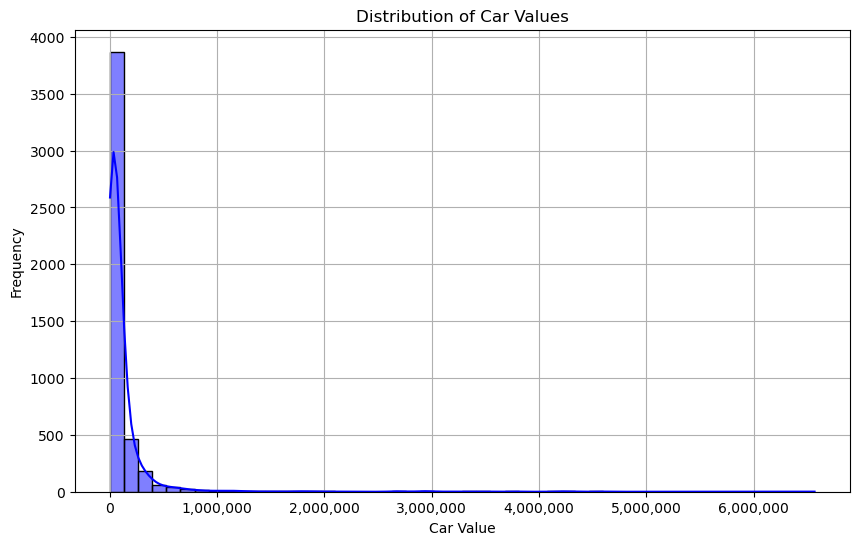

In [11]:
# Plotting the histogram of 'valor' column
plt.figure(figsize=(10, 6))
sns.histplot(fipe_data['valor'], bins=50, kde=True, color='blue')
plt.title("Distribution of Car Values")
plt.xlabel("Car Value")
plt.ylabel("Frequency")

# Adjusting x-axis to avoid scientific notation
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.savefig('../assets/car_value_histplot.png')

plt.grid(True)

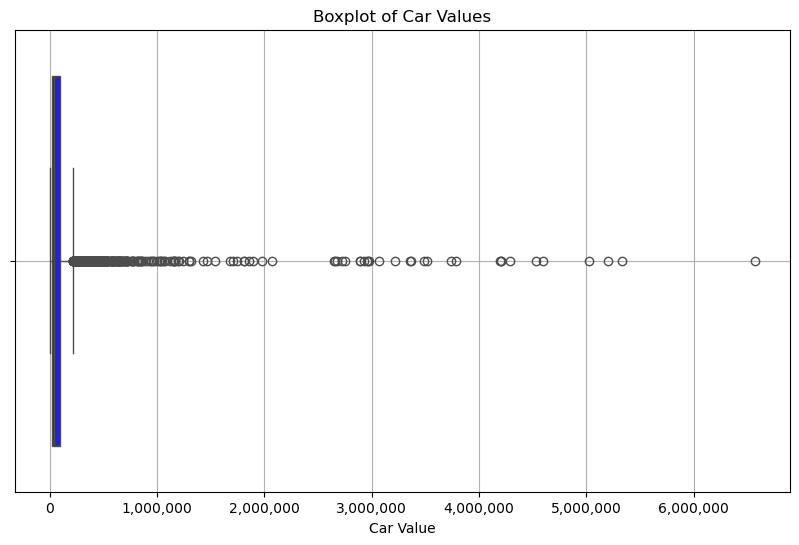

In [12]:
# Plotting the boxplot of 'valor' column
plt.figure(figsize=(10, 6))
sns.boxplot(x=fipe_data['valor'], color='blue')
plt.title("Boxplot of Car Values")
plt.xlabel("Car Value")

# Adjusting x-axis for boxplot
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.grid(True)

#### Visualizing Car Values Without Outliers

To improve the clarity of the visualizations and focus on the majority of the data, we decided to temporarily exclude outliers only in the visualizations. This allows us to better see the distribution of car values without affecting the underlying dataset.

We used the **Interquartile Range (IQR)** method to define the upper limit for values to be considered as outliers. Outliers are considered as values beyond 1.5 times the IQR above the third quartile or below the first quartile.

However, it is important to note that these outliers are not removed from the dataset itself, only from the visual representation, allowing us to focus on the typical car prices for more effective analysis and modeling.

- The **histogram** shows the distribution of car prices without the influence of outliers in the visualization.
- The **boxplot** helps to visualize the spread and central tendency of the data while excluding extreme values from the plot.



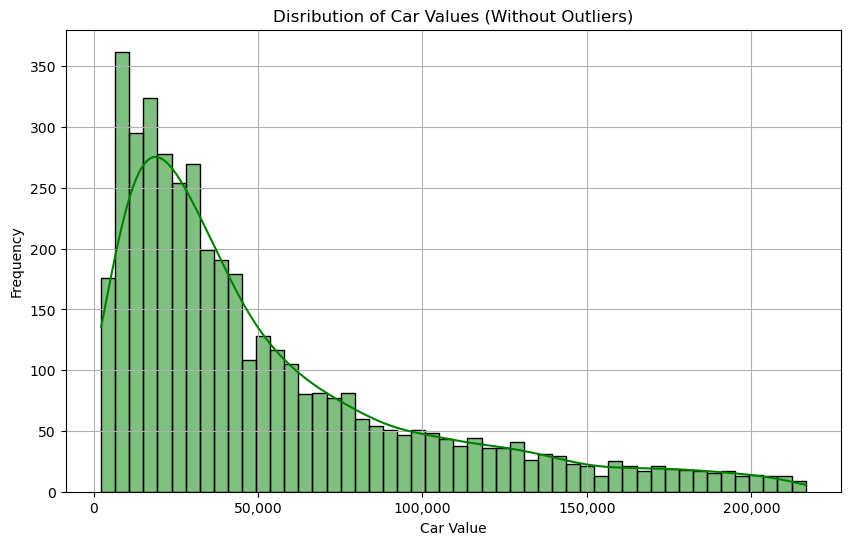

In [13]:
# Define the upper limit to trim outliers for visualization
upper_limit = fipe_data['valor'].quantile(0.75) + 1.5 * (fipe_data['valor'].quantile(0.75) - fipe_data['valor'].quantile(0.25))

# Filter the data only for visualization (do not modify the original dataset)
filtered_data_for_viz = fipe_data[fipe_data['valor'] <= upper_limit]

# Plotting the histogram of 'valor' column without outliers
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data_for_viz['valor'], bins=50, kde=True, color='green')
plt.title('Disribution of Car Values (Without Outliers)')
plt.xlabel('Car Value')
plt.ylabel('Frequency')

# Adjusting x-axis to avoid scientific notation
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.savefig('../assets/car_value_no_outlier_histplot.png')


plt.grid(True)


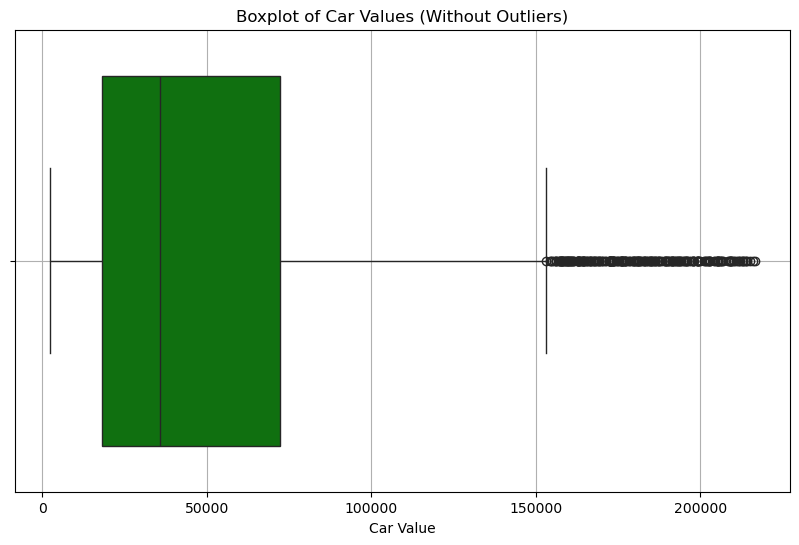

In [14]:
# Plotting the boxplot of 'valor' column without outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=filtered_data_for_viz['valor'], color='green')
plt.title('Boxplot of Car Values (Without Outliers)')
plt.xlabel('Car Value')

plt.grid(True)

### Distribuition of brands

In [15]:
# Generate statistics about 'marca' column
brand_stats = fipe_data['marca'].describe()

# Count of null values in 'brand' column
brand_null_count = fipe_data['marca'].isnull().sum()

print(f"Statistics about 'brand' column:\n{brand_stats}")
print("\n")
print(f"Null values in 'brand' column: {brand_null_count}")

Statistics about 'brand' column:
count               4713
unique                66
top       GM - Chevrolet
freq                 794
Name: marca, dtype: object


Null values in 'brand' column: 0


In [16]:
# Create table with brands
brands_series = fipe_data['marca'].value_counts()
brands_df = pd.DataFrame(data=brands_series).reset_index()

# How much of observation
top_n_brands = 10
top_brands_sum = brands_df['count'].head(top_n_brands).sum()
total_observations = fipe_data['marca'].count()
top_brands_from_total = top_brands_sum / total_observations
top_brands_from_total

# List name of top n brands
list_top_n_brands = brands_df['marca'].head(top_n_brands)

print(f"Top {top_n_brands} represent {top_brands_from_total.round(2)*100}% of observations")
print("\n")
print(f"List of {top_n_brands}:\n{list_top_n_brands}")

Top 10 represent 80.0% of observations


List of 10:
0    GM - Chevrolet
1              Fiat
2              Ford
3               BMW
4              Audi
5           Citroën
6     Mercedes-Benz
7             Honda
8           Hyundai
9          Chrysler
Name: marca, dtype: object


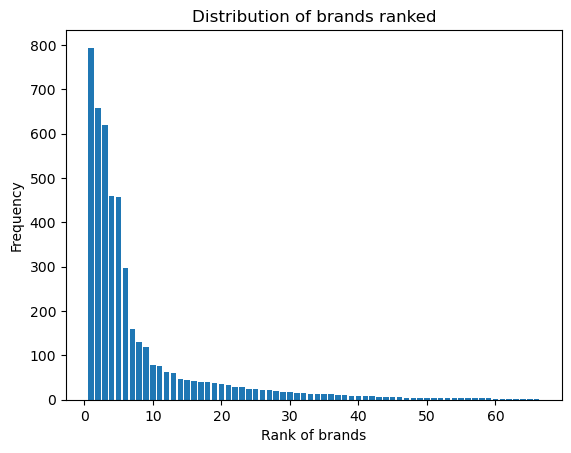

In [17]:
# Create table with brands ranked by frequency
brands_df['rank'] = brands_df.index + 1

# Plotting distribuition of brands
fig, ax = plt.subplots()
ax.bar(brands_df['rank'], brands_df['count'])
ax.set_title('Distribution of brands ranked')
ax.set_xlabel('Rank of brands')
ax.set_ylabel('Frequency')

plt.savefig('../assets/brands_rank.png')

plt.show()

#### Understanding distribuition of brands

From this section we could learn that a small set of brands represents the majority of observations in the dataset - only the top 10 represents 80% of observations.

The bar plot of frequency of brands by their rank helps to illustrate the "long tail" of less representative brands after the 10th brand.

### Analysis of engine, version, category and transmission type categories

In [18]:
# Prepare the report using describe for categorical columns
descriptive_report = fipe_data[['version', 'engine', 'category']].describe(include=[object])

# Calculate additional quality metrics
missing_values = fipe_data[['version', 'engine', 'category']].isnull().sum()
unique_values = fipe_data[['version', 'engine', 'category']].nunique()
mode_values = fipe_data[['version', 'engine', 'category']].mode().iloc[0]
most_frequent_counts = fipe_data[['version', 'engine', 'category']].apply(lambda x: x.value_counts().iloc[0])

# Combine the descriptive statistics with the additional metrics
descriptive_report.loc['missing'] = missing_values
descriptive_report.loc['unique'] = unique_values
descriptive_report.loc['mode'] = mode_values
descriptive_report.loc['most_frequent_count'] = most_frequent_counts

# Display the final report
pprint.pprint(descriptive_report)

                    version engine category
count                  4163   3253      923
unique                   52      6        8
top                     2.0  Other   Pickup
freq                    715   1205      344
missing                 550   1460     3790
mode                    2.0  Other   Pickup
most_frequent_count     715   1205      344


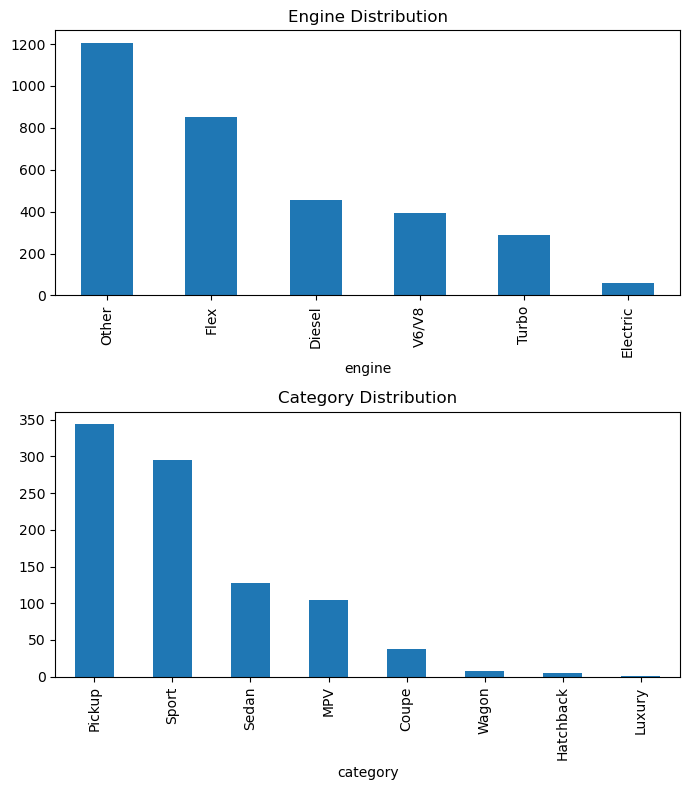

In [19]:
# Plot distribution of the'engine', and 'category' columns
fig, axes = plt.subplots(2, 1, figsize=(7, 8))

fipe_data['engine'].value_counts().plot(kind='bar', ax=axes[0], title='Engine Distribution')
fipe_data['category'].value_counts().plot(kind='bar', ax=axes[1], title='Category Distribution')

plt.savefig('../assets/engine_category_distribution.png')

plt.tight_layout()

In [20]:
# Analysing transmission_type data

trans_count_values = fipe_data[['transmission_type']].count().sum()
trans_missing_values = fipe_data['transmission_type'].isnull().sum()

print(f"Transmission type classification has {trans_count_values} values")
print(f"Transmission type classification has {trans_missing_values} missing values")


Transmission type classification has 1478 values
Transmission type classification has 3235 missing values


In [21]:
# Proportion of transmission types
fipe_data['transmission_type'].value_counts(normalize=True)

transmission_type
Auto     0.72
Manual   0.28
Name: proportion, dtype: float64

#### Analysis of the `version`, `engine`, `category`, `transmission_type` columns

This section provides an overview of the distribution and quality of the new columns (`version`, `engine`, and `category`) based on the results from the dataset.

1. **`version` Column**
   - **Count**: There are 4,591 entries for the `version` column.
   - **Unique Values**: The `version` column contains 286 unique values, indicating a variety of car versions.
   - **Most Frequent Value**: The most common version is "1.6", which appears 440 times.
   - **Missing Values**: There are 122 missing values in the `version` column.
   - **Observations**: The `version` column contains a wide range of values, primarily numerical, possibly indicating engine sizes or version specifications for the vehicles.


2. **`engine` Column**
   - **Count**: The `engine` column contains 3,192 entries, suggesting that not all vehicles have a clearly defined engine type.
   - **Unique Values**: This column has 5 unique engine types. The most frequent engine type is "Other", which is observed 1,205 times. This indicates that a significant portion of the dataset lacks specific details about the engine or has generic data listed as "Other".
   - **Missing Values**: The `engine` column has 1,521 missing values, which is quite a large proportion, suggesting a lot of incomplete or undefined engine data.
   - **Observations**: The data in this column is sparse, with many entries categorized under the "Other" label. Further cleaning or standardization might be needed to provide more specific engine information.


3. **`category` Column**
   - **Count**: The `category` column has only 905 entries, making it significantly smaller than the other two columns.
   - **Unique Values**: There are 9 unique categories in this column, which could represent different types of vehicles such as "SUV", "Sedan", or "Hatch".
   - **Most Frequent Value**: The most common category is "Other", which appears 308 times, similarly to the `engine` column.
   - **Missing Values**: This column has 3,808 missing values, representing a large proportion of the dataset. This high number of missing entries suggests that category data is often not available for many vehicles.
   - **Observations**: Like the `engine` column, the `category` column also contains many missing values and instances of the "Other" category. This may require further refinement to improve the consistency and completeness of the data. 

4. **`transmission_type` Column**
    - **Count**: The `transmission_type` category has 1478 values, and 3235 missing values; majority of observations don't have this information
    - **Unique Values**: there are only the values of Manual or Automatic transmission
    - **Most frequent value**: is the Automatic transmission type


## Pre-processing and feature selection

In [22]:
fipe_features = fipe_data[['modelo', 'marca', 'comb', 'version', 'engine', 'category', 'transmission_type', 'doors', 'hp', 'valves']].drop_duplicates()
fipe_features.head(3)

,modelo,marca,comb,version,engine,category,transmission_type,doors,hp,valves
0,Integra GS 1.8,Acura,Gasolina,1.8,None,None,None,None,None,None
1,MARRUÁ AM 100 2.8 CS TDI Diesel,Agrale,Diesel,2.8,Diesel,None,None,None,None,None
2,MARRUÁ AM 200 2.8 CS TDI Diesel,Agrale,Diesel,2.8,Diesel,None,None,None,None,None


### Pre-processing

1. **Categorical features** will be turned into dummy features so they can be processed by the model.
2. **Numerical features** will be scaled using Standard Scaler (data has a mean of 0 and standard deviation of 1).
- The decision to use Standard Scaler rather than MinMax (that fits data in a range from 0 to 1), is to preserve outlier information, that can be later used to identify unique similarities.

In [23]:
fipe_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2061 entries, 0 to 77
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   modelo             2061 non-null   object
 1   marca              2061 non-null   object
 2   comb               2061 non-null   object
 3   version            1811 non-null   object
 4   engine             1418 non-null   object
 5   category           407 non-null    object
 6   transmission_type  693 non-null    object
 7   doors              629 non-null    object
 8   hp                 274 non-null    object
 9   valves             917 non-null    object
dtypes: object(10)
memory usage: 177.1+ KB


In [24]:
fipe_features = fipe_features.reset_index().drop(['index'], axis=1)
fipe_features

,modelo,marca,comb,version,engine,category,transmission_type,doors,hp,valves
0,Integra GS 1.8,Acura,Gasolina,1.8,None,None,None,None,None,None
1,MARRUÁ AM 100 2.8 CS TDI Diesel,Agrale,Diesel,2.8,Diesel,None,None,None,None,None
2,MARRUÁ AM 200 2.8 CS TDI Diesel,Agrale,Diesel,2.8,Diesel,None,None,None,None,None
3,Hi-Topic STD Diesel,Asia Motors,Diesel,None,Diesel,None,None,None,None,None
4,DB9 Coupe 6.0 V12 510cv,ASTON MARTIN,Gasolina,6.0,Other,Coupe,None,None,5,None
...,...,...,...,...,...,...,...,...,...,...
2056,Fit Twist 1.5 Flex 16V 5p Aut.,Honda,Gasolina,1.5,Flex,None,Auto,5,None,16
2057,HR-V EX 1.8 Flexone 16V 5p Aut.,Honda,Gasolina,1.8,Flex,None,Auto,5,None,16
2058,AZERA 3.0 V6 24V 4p Aut.,Hyundai,Gasolina,3.0,V6/V8,None,Auto,4,None,24
2059,HB20S C.Style/C.Plus1.6 Flex 16V Aut. 4p,Hyundai,Gasolina,None,Flex,None,Auto,4,None,16


In [25]:
fipe_features.index.has_duplicates

False

In [26]:
# OneHotEncode CATEGORICAL features
from sklearn.preprocessing import OneHotEncoder

categorical_cols = ['marca','comb','version','engine','category','transmission_type']

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_data = encoder.fit_transform(fipe_features[categorical_cols])
fipe_features_encoded = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols))
fipe_features_encoded.head(3)

,marca_ASTON MARTIN,marca_Acura,marca_Agrale,marca_Alfa Romeo,marca_Asia Motors,marca_Audi,marca_BMW,marca_BRM,marca_BYD,marca_Baby,...,category_Luxury,category_MPV,category_Pickup,category_Sedan,category_Sport,category_Wagon,category_None,transmission_type_Auto,transmission_type_Manual,transmission_type_None
0,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00
1,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00
2,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00


#### Note: dealing with None values in categorical columns

Here, domain knowledge tells us that None columns are Missing at Random.
<br> For example, there is no way that a car has no transmission type.
<br> In this case, a transmission_type_None = 1 is not carrying any implicit information by being missing.
<br> So we can simply remove this as a considered feature.

In [27]:
none_patterns = ['_None', '_Other']

columns_to_drop = []
for col in fipe_features_encoded.columns:
    if any(col.lower().endswith(pattern.lower()) for pattern in none_patterns):
        columns_to_drop.append(col)

fipe_features_encoded = fipe_features_encoded.drop(columns=columns_to_drop)

In [28]:
# Scale NUMERICAL features
from sklearn.preprocessing import StandardScaler

# Getting numerical features and adding to dataframe
numerical_features = [col for col in fipe_features.columns if col not in categorical_cols]
numerical_features.pop(0)
fipe_features_processed = pd.concat([fipe_features[numerical_features].reset_index(drop=True), fipe_features_encoded], axis=1)

# Scaling
scaler = StandardScaler()
fipe_features_processed[numerical_features] = scaler.fit_transform(fipe_features_processed[numerical_features])

In [29]:
fipe_features_processed[['doors','hp','valves']].describe()

,doors,hp,valves
count,629.00,274.00,917.00
mean,-0.00,-0.00,0.00
std,1.00,1.00,1.00
min,-2.21,-0.86,-1.43
25%,-0.19,-0.86,-1.12
50%,-0.19,-0.34,0.12
75%,0.82,0.71,0.12
max,0.82,3.32,5.10


### Feature selection

#### VarianceThreshold
   1. only considers features and not outputs, thus it can be used for unsupervised learning.
   2. Serves as a first step to remove features with low variance, as they provide little information.
   3. It calculates variance of each feature and removes those below the specified threshold.
   4. The threshold defines "how constant" a feature should be before it is discarded.
   5. My goal is to define a optimal threshold that keeps the fewer more informative features.
   6. I can see this ranking features by its variance and looking for an "elbow", where variance drops significantly.
   7. On numberical data Stardard scaled, variance will be around 1 (stad. dev. is 1).

<br>
Other strategies to select features would involve creating a pseudo-target to evaluate feature importance.
<br>
Next step is to understand correlation between selected features.

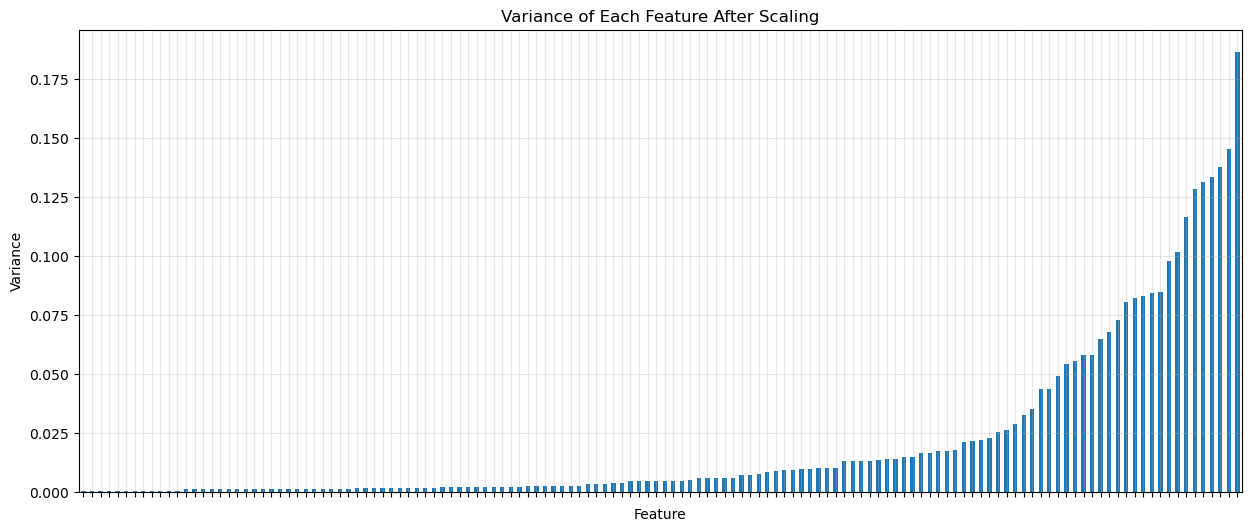

<Figure size 640x480 with 0 Axes>

In [47]:
# Plotting variance to define the threashold

variances = fipe_features_encoded.var().sort_values(ascending=True)

import matplotlib.pyplot as plt
variances.plot(kind='bar', figsize=(15, 6))
plt.title('Variance of Each Feature After Scaling')
plt.ylabel('Variance')
plt.xlabel('Feature')
plt.gca().set_xticklabels([])
plt.grid(alpha=0.3)
plt.show()

plt.savefig('../assets/features_variance.png')

<b>Here, variance will have the value to explain how one observation is different from one another considering a specific feature. </b>

In [31]:
# Applying Variance Threshold
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=.025 * (1 - .025))
X_selected = selector.fit_transform(fipe_features_processed)
selected_feature_names = fipe_features_processed.columns[selector.get_support()]
X_selected_df = pd.DataFrame(X_selected, columns=selected_feature_names)
print(f"Shape of data after VarianceThreshold: {X_selected_df.shape}")
print(f"Selected features: {selected_feature_names}")

Shape of data after VarianceThreshold: (2061, 32)
Selected features: Index(['doors', 'hp', 'valves', 'marca_Audi', 'marca_BMW', 'marca_Citroën',
       'marca_Fiat', 'marca_Ford', 'marca_GM - Chevrolet', 'marca_Hyundai',
       'marca_Land Rover', 'marca_Mercedes-Benz', 'comb_Diesel',
       'comb_Gasolina', 'version_1.0', 'version_1.4', 'version_1.5',
       'version_1.6', 'version_1.8', 'version_2.0', 'version_2.5',
       'version_2.8', 'version_3.0', 'engine_Diesel', 'engine_Flex',
       'engine_Turbo', 'engine_V6/V8', 'category_Pickup', 'category_Sedan',
       'category_Sport', 'transmission_type_Auto', 'transmission_type_Manual'],
      dtype='object')


A variance of 0.025 for a car brand dummy feature means that the brand appears in approximately 2.57% of your dataset's cars, OR it appears in approximately 97.43% of your dataset's cars (this is the `p` of variance, proportion)

Both scenarios represent a low level of variation for that specific brand's presence in your dataset.

If it's at 2.57% (very rare), that brand offers little information for distinguishing between the vast majority of cars.
If it's at 97.43% (very common), it also offers little information because almost every car has that brand (or is that brand), making it nearly a constant feature.

#### Correlation between features

1. High correlated features are an indication of redundant information
2. Strong negative correlation is expected in one-hot encoded features, as some can be mutually exclusive (that's the case for transmission type, although this is impacted by the 'None' value)

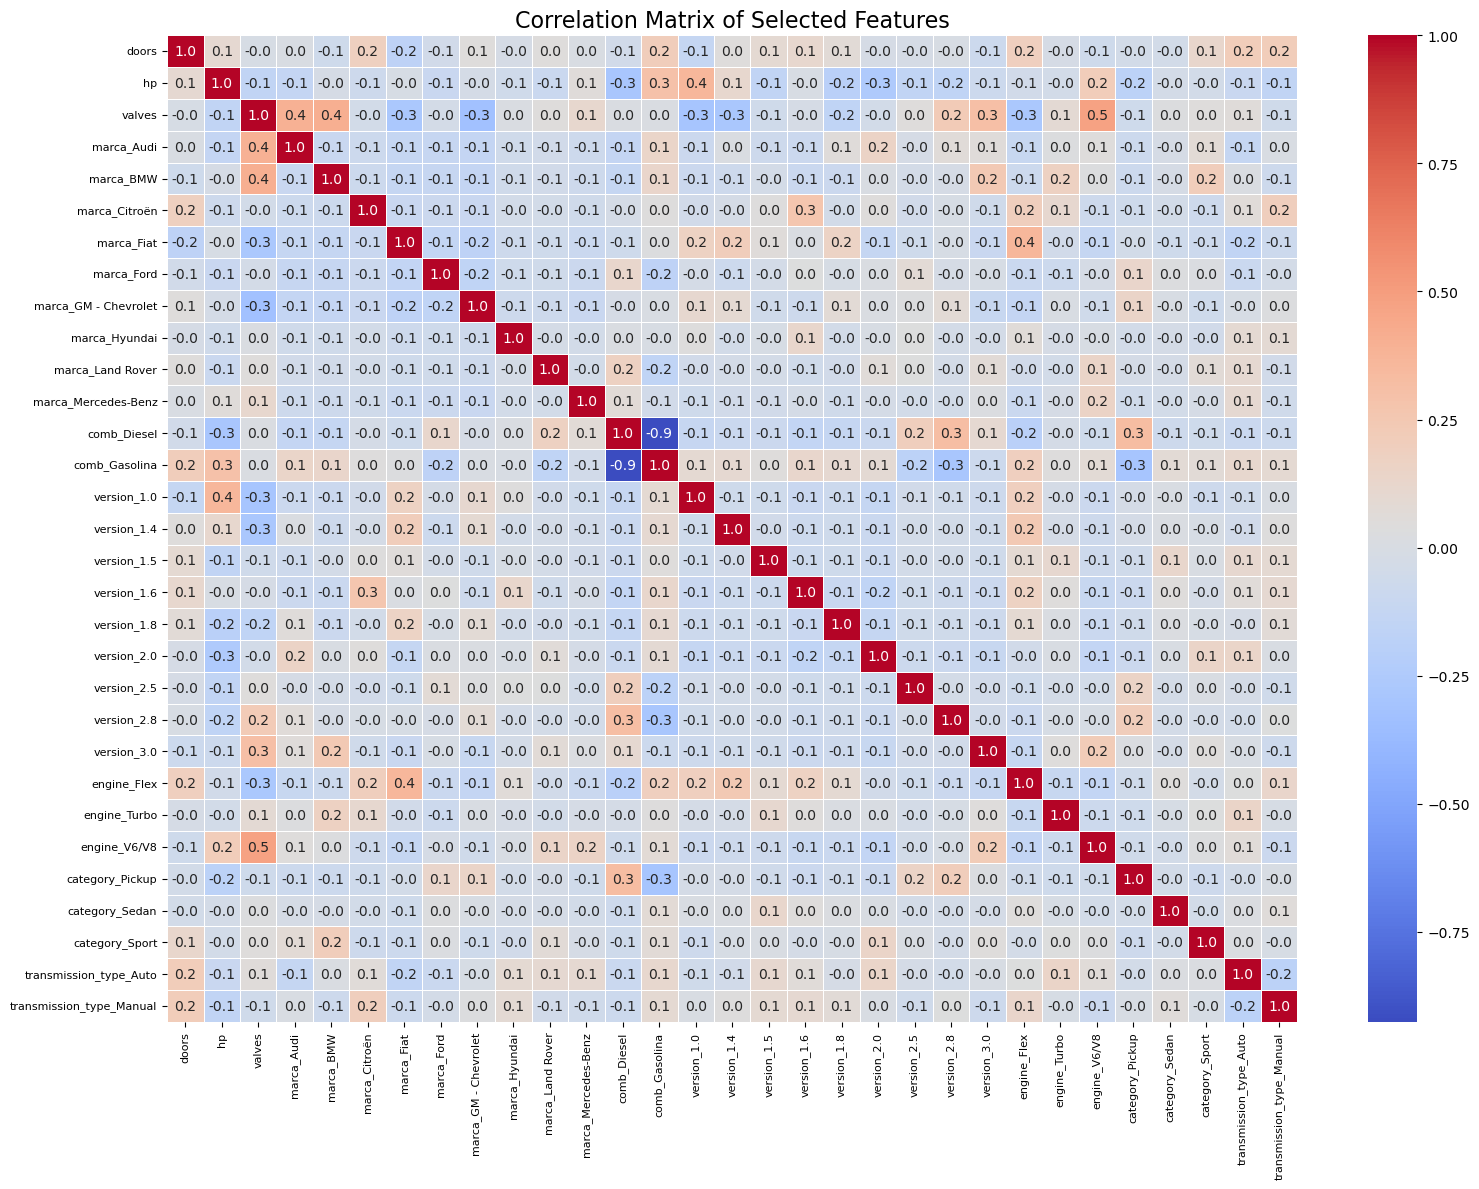

<Figure size 640x480 with 0 Axes>

In [48]:
correlation_matrix = X_selected_df.corr()

plt.figure(figsize=(16, 12)) 
sns.heatmap(correlation_matrix,
            annot=True,    
            cmap='coolwarm', 
            fmt=".1f",      
            linewidths=.5) 

plt.title('Correlation Matrix of Selected Features', fontsize=16)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

plt.savefig('../assets/features_corr_matrix.png')

Observations:
- comb_Gasolina and comb_Diesel is one example of strong negative correlation in the case of a mutually exclusive feature.
- engine_Diesel and comb_Diesel has a strong correlation, this is redundant information that can be removed.
- Decision of which feature to keep will depend on domain knowledge (which is more important), or keeping the one with higher correlation
- Another example is engine_V6/V8 and valves, as the same information is used to classify it. Although, domain knowledge suggests they are representing different roles here.

In [33]:
X_selected_df = X_selected_df.drop('engine_Diesel', axis=1)

## Dimensionality reduction

1. This is used to condense multiple correlated features into Principal Components
2. They are a linear combination of different features: `PC1 = 0.6 * horsepower + 0.3 * engine_size - 0.2 * fuel_type_diesel`
3. After transformation, multicolinearity is elimited between each PC, and they become orthogonal (uncorrelated)
4. The main trade of this is loosing interpretability - being able to say what are the main features making two models similar

In [34]:
# PCA does not accept NaN values, present in numerical categories

X_selected_df_nonan = X_selected_df.drop(['doors', 'hp', 'valves'], axis=1)

Note:
- Any solution to use this columns with NaN values, or should I give up completely?

In [37]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95) # number of components that explain 95% of variance

X_selected_pca = pca.fit_transform(X_selected_df_nonan)
X_selected_pca_df = pd.DataFrame(X_selected_pca, columns=[f'PC_{i+1}' for i in range(X_selected_pca.shape[1])])
X_selected_pca_df.head(5)

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_14,PC_15,PC_16,PC_17,PC_18,PC_19,PC_20,PC_21,PC_22,PC_23
0,0.15,-0.18,-0.29,0.05,-0.17,-0.09,0.17,-0.19,-0.41,0.51,...,-0.35,0.20,0.07,-0.14,-0.05,0.09,0.09,0.08,-0.24,-0.01
1,-1.26,-0.15,0.17,-0.04,0.04,-0.08,-0.32,-0.11,-0.05,0.00,...,0.03,0.11,0.02,-0.16,-0.14,-0.30,-0.08,-0.49,-0.20,0.21
2,-1.26,-0.15,0.17,-0.04,0.04,-0.08,-0.32,-0.11,-0.05,0.00,...,0.03,0.11,0.02,-0.16,-0.14,-0.30,-0.08,-0.49,-0.20,0.21
3,-1.15,-0.14,0.15,-0.09,0.04,-0.06,-0.24,-0.06,-0.04,-0.03,...,-0.06,0.18,-0.12,0.02,-0.17,-0.07,0.03,0.03,-0.08,-0.05
4,0.08,-0.08,-0.27,-0.06,-0.14,0.01,0.02,-0.02,-0.07,-0.08,...,-0.05,0.22,0.00,-0.07,-0.07,0.07,0.10,0.05,-0.14,0.03


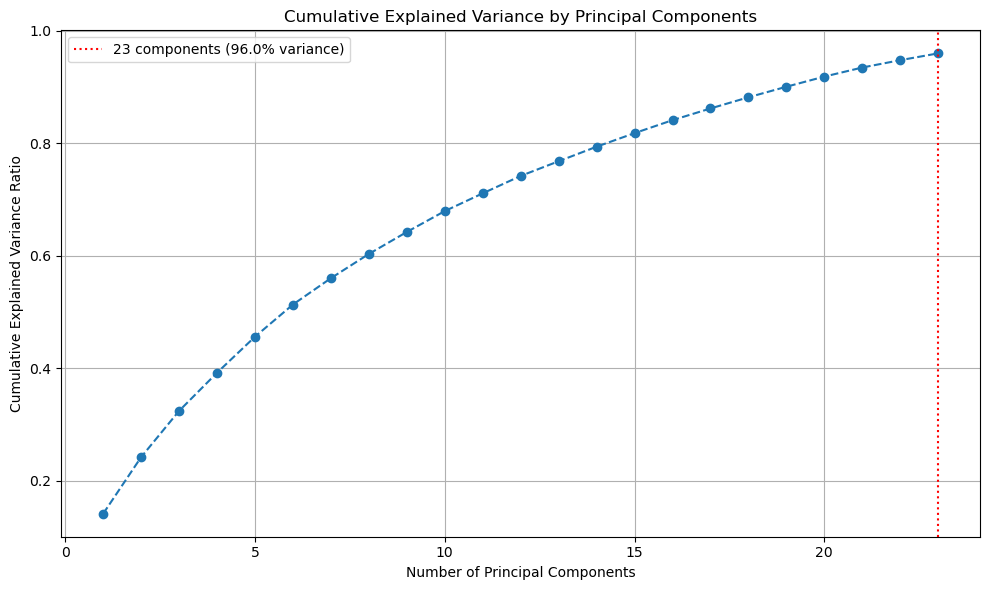

<Figure size 640x480 with 0 Axes>

In [49]:
explained_variance_ratio_cumulative = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio_cumulative) + 1), explained_variance_ratio_cumulative, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.axvline(x=pca.n_components_, color='r', linestyle=':', label=f'{pca.n_components_} components ({pca.explained_variance_ratio_.sum()*100:.1f}% variance)')
plt.legend()
plt.tight_layout()
plt.show()

plt.savefig('../assets/pca_cumulative_explained_variance.png')

1. Variance means how the information is spread out.
2. High variance means it is easy to distinguish difference between observations.
3. PCs are added by the amount of variance they capture. PC1 is the linear combination that shows most spread. PC2 is the second most amount of variance.
4. Explained variance ratio is how each PC is explaining total variance in the dataset (not in feature scope as VarianceThreashold)
5. We need 23 components to preserve 95% of original variance, that means that features available were not that correlated.

# KNN Models

### KNN Model without dimentionality reduction

In [39]:
from sklearn.neighbors import NearestNeighbors

knn_model = NearestNeighbors(n_neighbors=5, metric='euclidean')
knn_model.fit(X_selected_df_nonan)


NearestNeighbors(metric='euclidean')

In [40]:
target_car_index = 9
target_car_features = X_selected_df_nonan.iloc[[target_car_index]]

In [41]:
distances, indices = knn_model.kneighbors(target_car_features)

In [42]:
for i in range(0, len(indices[0])):
    neighbor_index = indices[0][i]
    neighbor_distance = distances[0][i]

    similar_car_details = fipe_features.loc[neighbor_index]

    print(similar_car_details)


modelo               A3 1.8 Turbo 5p Aut.
marca                                Audi
comb                             Gasolina
version                               1.8
engine                              Turbo
category                             None
transmission_type                    Auto
doors                                   5
hp                                   None
valves                               None
Name: 409, dtype: object
modelo               A3 1.8 Turbo 3p Aut.
marca                                Audi
comb                             Gasolina
version                               1.8
engine                              Turbo
category                             None
transmission_type                    Auto
doors                                   3
hp                                   None
valves                               None
Name: 9, dtype: object
modelo               A4 1.8 Turbo
marca                        Audi
comb                     Gasolina
version   

In [43]:
fipe_features.loc[target_car_index]

modelo               A3 1.8 Turbo 3p Aut.
marca                                Audi
comb                             Gasolina
version                               1.8
engine                              Turbo
category                             None
transmission_type                    Auto
doors                                   3
hp                                   None
valves                               None
Name: 9, dtype: object

### KNN Model with dimentionality reduction

In [44]:
from sklearn.neighbors import NearestNeighbors

knn_model_pca = NearestNeighbors(n_neighbors=5, metric='euclidean')
knn_model_pca.fit(X_selected_pca_df)

NearestNeighbors(metric='euclidean')

In [45]:
target_car_index = 9
target_car_features = X_selected_pca_df.iloc[[target_car_index]]

distances_pca, indices_pca = knn_model_pca.kneighbors(target_car_features)

In [46]:
for i in range(0, len(indices[0])):
    neighbor_index = indices_pca[0][i]
    neighbor_distance = distances_pca[0][i]

    similar_car_details = fipe_features.loc[neighbor_index]

    print(similar_car_details)

modelo               A3 1.8 Turbo 5p Aut.
marca                                Audi
comb                             Gasolina
version                               1.8
engine                              Turbo
category                             None
transmission_type                    Auto
doors                                   5
hp                                   None
valves                               None
Name: 409, dtype: object
modelo               A3 1.8 Turbo 3p Aut.
marca                                Audi
comb                             Gasolina
version                               1.8
engine                              Turbo
category                             None
transmission_type                    Auto
doors                                   3
hp                                   None
valves                               None
Name: 9, dtype: object
modelo               A4 1.8 Avant Aut.
marca                             Audi
comb                          Gaso